In [1]:
!pip install torch torchvision timm

# Import necessary libraries

In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import timm
from tqdm import tqdm

# Import Dataset

In [3]:
# Define paths to your dataset
data_dir = '/kaggle/input/train-bci-amend'

# EDA

In [4]:
# Create a DataFrame to hold image paths and labels
data = []
for label in ['class_0', 'class_1+', 'class_2+', 'class_3+']:
    label_dir = os.path.join(data_dir, label)
    for img_name in os.listdir(label_dir):
        if img_name.endswith('.png'):
            img_path = os.path.join(label_dir, img_name)
            data.append([img_path, label])

df = pd.DataFrame(data, columns=['img_path', 'label'])

# Map labels to numeric values
label_mapping = {'class_0': 0, 'class_1+': 1, 'class_2+': 2, 'class_3+': 3}
df['label'] = df['label'].map(label_mapping)

# Display the counts for each class and the total number of images
print("Number of images in each class:")
print(df['label'].value_counts().sort_index())
print("\nTotal number of images:", df['label'].value_counts().sum())

Number of images in each class:
label
0     202
1     919
2    1697
3    1078
Name: count, dtype: int64

Total number of images: 3896


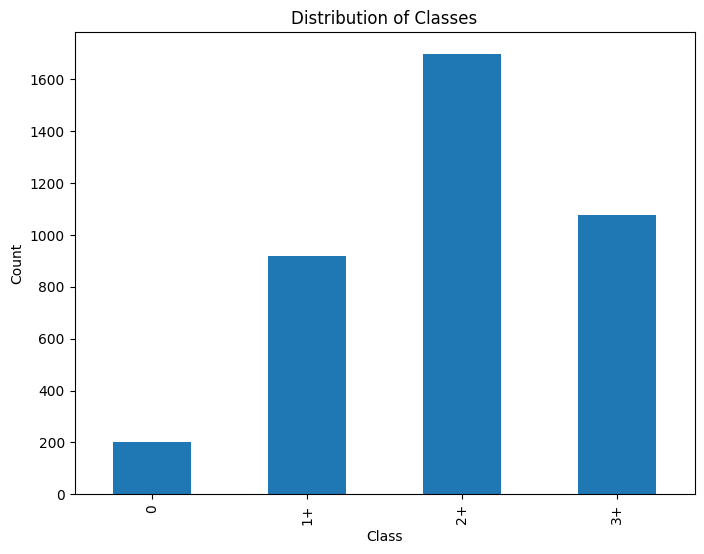

In [5]:
# Plot the distribution of classes
plt.figure(figsize=(8, 6))
df['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3], labels=['0', '1+', '2+', '3+'])
plt.show()


In [6]:
# Ensure we get at least one image from each class
samples = []
for label in label_mapping.values():
    samples.append(df[df['label'] == label].sample(1, random_state=42).values[0])
remaining_samples = df.sample(n=7-len(samples), random_state=42).values
samples.extend(remaining_samples)
import random
random.shuffle(samples)



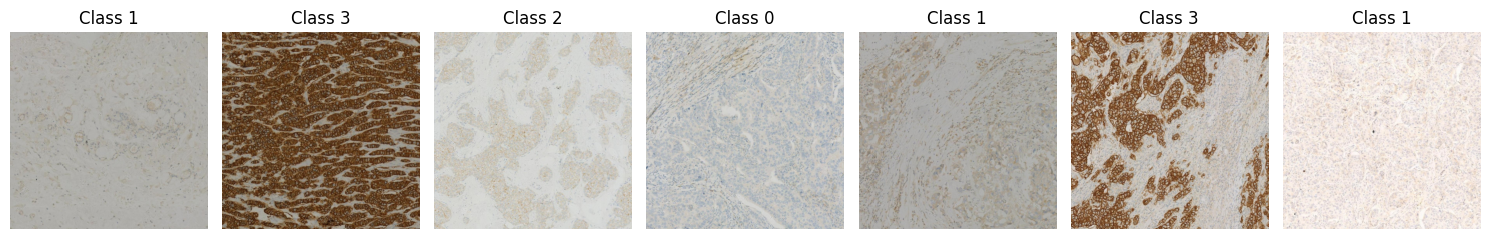

In [7]:
# Visualize the random samples
def visualize_random_samples(samples):
    fig, axes = plt.subplots(1, len(samples), figsize=(15, 5))
    for i in range(len(samples)):
        img_path = samples[i][0]
        label = samples[i][1]
        image = Image.open(img_path)
        axes[i].imshow(image)
        axes[i].set_title(f'Class {label}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
visualize_random_samples(samples)

class HER2Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# HRNetClassifier class

In [8]:
class HRNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(HRNetClassifier, self).__init__()
        self.model = timm.create_model('hrnet_w30', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

# Define the HER2Dataset class

In [9]:
# Define the HER2Dataset class
class HER2Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['img_path']
        label = self.df.iloc[idx]['label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Training function

In [10]:
# Define the training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

# Evaluation function

In [11]:
# Define the evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(test_loader.dataset)
    return epoch_loss, all_preds, all_labels

# Data augmentation

In [12]:
# Define image transformations with enhanced data augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),  # Add vertical flip
    transforms.RandomRotation(15),  # Increase rotation angle
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
# Load entire dataset for training
train_dataset = HER2Dataset(df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [14]:
# Initialize model, criterion, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = HRNetClassifier(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

In [15]:
# Initialize an empty list to store training losses
train_losses = []

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}')
    scheduler.step()

100%|██████████| 122/122 [02:44<00:00,  1.35s/it]


Epoch 1/50, Loss: 0.9167


100%|██████████| 122/122 [02:23<00:00,  1.18s/it]


Epoch 2/50, Loss: 0.7003


100%|██████████| 122/122 [02:25<00:00,  1.20s/it]


Epoch 3/50, Loss: 0.5815


100%|██████████| 122/122 [02:22<00:00,  1.17s/it]


Epoch 4/50, Loss: 0.5211


100%|██████████| 122/122 [02:23<00:00,  1.17s/it]


Epoch 5/50, Loss: 0.4403


100%|██████████| 122/122 [02:24<00:00,  1.19s/it]


Epoch 6/50, Loss: 0.3756


100%|██████████| 122/122 [02:37<00:00,  1.29s/it]


Epoch 7/50, Loss: 0.3268


100%|██████████| 122/122 [02:43<00:00,  1.34s/it]


Epoch 8/50, Loss: 0.2696


100%|██████████| 122/122 [02:41<00:00,  1.33s/it]


Epoch 9/50, Loss: 0.2472


100%|██████████| 122/122 [02:43<00:00,  1.34s/it]


Epoch 10/50, Loss: 0.2333


100%|██████████| 122/122 [02:39<00:00,  1.31s/it]


Epoch 11/50, Loss: 0.2291


100%|██████████| 122/122 [02:44<00:00,  1.34s/it]


Epoch 12/50, Loss: 0.2257


100%|██████████| 122/122 [02:39<00:00,  1.30s/it]


Epoch 13/50, Loss: 0.2239


100%|██████████| 122/122 [02:32<00:00,  1.25s/it]


Epoch 14/50, Loss: 0.2324


100%|██████████| 122/122 [02:25<00:00,  1.19s/it]


Epoch 15/50, Loss: 0.2583


100%|██████████| 122/122 [02:23<00:00,  1.17s/it]


Epoch 16/50, Loss: 0.2747


100%|██████████| 122/122 [02:23<00:00,  1.17s/it]


Epoch 17/50, Loss: 0.3189


100%|██████████| 122/122 [02:23<00:00,  1.18s/it]


Epoch 18/50, Loss: 0.3234


100%|██████████| 122/122 [02:22<00:00,  1.17s/it]


Epoch 19/50, Loss: 0.3488


100%|██████████| 122/122 [02:21<00:00,  1.16s/it]


Epoch 20/50, Loss: 0.3512


100%|██████████| 122/122 [02:21<00:00,  1.16s/it]


Epoch 21/50, Loss: 0.3147


100%|██████████| 122/122 [02:23<00:00,  1.18s/it]


Epoch 22/50, Loss: 0.2965


100%|██████████| 122/122 [02:24<00:00,  1.18s/it]


Epoch 23/50, Loss: 0.2461


100%|██████████| 122/122 [02:24<00:00,  1.19s/it]


Epoch 24/50, Loss: 0.2248


100%|██████████| 122/122 [02:23<00:00,  1.18s/it]


Epoch 25/50, Loss: 0.2189


100%|██████████| 122/122 [02:21<00:00,  1.16s/it]


Epoch 26/50, Loss: 0.1861


100%|██████████| 122/122 [02:25<00:00,  1.19s/it]


Epoch 27/50, Loss: 0.1375


100%|██████████| 122/122 [02:21<00:00,  1.16s/it]


Epoch 28/50, Loss: 0.1268


100%|██████████| 122/122 [02:27<00:00,  1.20s/it]


Epoch 29/50, Loss: 0.1082


100%|██████████| 122/122 [02:28<00:00,  1.22s/it]


Epoch 30/50, Loss: 0.0971


100%|██████████| 122/122 [02:27<00:00,  1.21s/it]


Epoch 31/50, Loss: 0.1016


100%|██████████| 122/122 [02:24<00:00,  1.18s/it]


Epoch 32/50, Loss: 0.1046


100%|██████████| 122/122 [02:24<00:00,  1.19s/it]


Epoch 33/50, Loss: 0.1074


100%|██████████| 122/122 [02:19<00:00,  1.15s/it]


Epoch 34/50, Loss: 0.1032


100%|██████████| 122/122 [02:19<00:00,  1.15s/it]


Epoch 35/50, Loss: 0.1313


100%|██████████| 122/122 [02:20<00:00,  1.15s/it]


Epoch 36/50, Loss: 0.1663


100%|██████████| 122/122 [02:20<00:00,  1.15s/it]


Epoch 37/50, Loss: 0.1670


100%|██████████| 122/122 [02:20<00:00,  1.16s/it]


Epoch 38/50, Loss: 0.2493


100%|██████████| 122/122 [02:20<00:00,  1.16s/it]


Epoch 39/50, Loss: 0.2495


100%|██████████| 122/122 [02:22<00:00,  1.16s/it]


Epoch 40/50, Loss: 0.2586


100%|██████████| 122/122 [02:29<00:00,  1.22s/it]


Epoch 41/50, Loss: 0.2272


100%|██████████| 122/122 [02:25<00:00,  1.19s/it]


Epoch 42/50, Loss: 0.1997


100%|██████████| 122/122 [02:22<00:00,  1.17s/it]


Epoch 43/50, Loss: 0.1989


100%|██████████| 122/122 [02:26<00:00,  1.20s/it]


Epoch 44/50, Loss: 0.1714


100%|██████████| 122/122 [02:35<00:00,  1.28s/it]


Epoch 45/50, Loss: 0.1464


100%|██████████| 122/122 [02:27<00:00,  1.21s/it]


Epoch 46/50, Loss: 0.1110


100%|██████████| 122/122 [02:21<00:00,  1.16s/it]


Epoch 47/50, Loss: 0.0991


100%|██████████| 122/122 [02:21<00:00,  1.16s/it]


Epoch 48/50, Loss: 0.0894


100%|██████████| 122/122 [02:22<00:00,  1.17s/it]


Epoch 49/50, Loss: 0.0800


100%|██████████| 122/122 [02:20<00:00,  1.15s/it]

Epoch 50/50, Loss: 0.0697


# Define the Test DataLoader

In [16]:
# Define the batch size
batch_size = 32  # or any other value that suits your system

# Define the path to your test dataset
test_data_dir = '/kaggle/input/test-bci-amend'  

# Create a DataFrame to hold test image paths and labels
test_data = []
for label in ['class_0', 'class_1+', 'class_2+', 'class_3+']:
    label_dir = os.path.join(test_data_dir, label)
    for img_name in os.listdir(label_dir):
        if img_name.endswith('.png'):
            img_path = os.path.join(label_dir, img_name)
            test_data.append([img_path, label])

test_df = pd.DataFrame(test_data, columns=['img_path', 'label'])
test_df['label'] = test_df['label'].map(label_mapping)

# Create Dataset and DataLoader for test data
test_dataset = HER2Dataset(test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [17]:
# Evaluate the model on the test dataset
test_loss, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}')


100%|██████████| 31/31 [00:32<00:00,  1.04s/it]

Test Loss: 0.2485


# Classificaation Report

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Generate the classification report
class_report = classification_report(test_labels, test_preds, target_names=['class_0', 'class_1+', 'class_2+', 'class_3+'])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

     class_0       0.85      0.87      0.86        38
    class_1+       0.91      0.88      0.89       235
    class_2+       0.92      0.93      0.93       446
    class_3+       0.93      0.94      0.94       258

    accuracy                           0.92       977
   macro avg       0.90      0.90      0.90       977
weighted avg       0.92      0.92      0.92       977



# Confusion Matrix

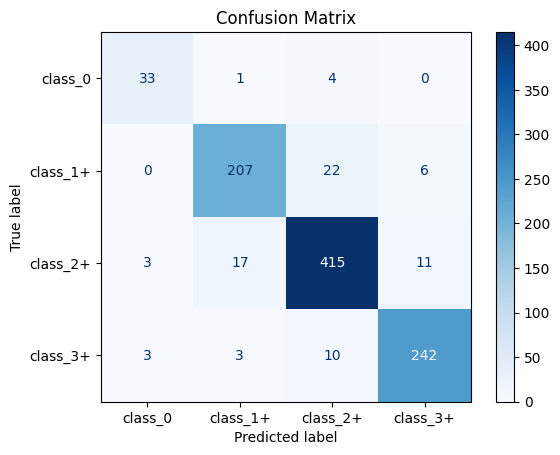

In [19]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['class_0', 'class_1+', 'class_2+', 'class_3+'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Save Model

In [ ]:
# Save the model if needed
torch.save(model.state_dict(), 'hrnet_bci_classifier_91%.pth')